In [1]:
from utils import *

Indexing words...
Indexed 5709 words in output
keep_words 3538 / 5706 = 0.6200


In [2]:
captions_train_trimmed = []

for captions in captions_train_filtered:
    keep_captions = []
    for caption in captions:
        keep = True

        for word in caption.split(' '):
            if word not in output_lang.word2index:
                keep = False
                break

        # Remove if pair doesn't match input and output conditions
        if keep:
            keep_captions.append(caption)
    
    captions_train_trimmed.append(keep_captions)

L1 = sum([len(captions) for captions in captions_train_trimmed])
L2 = sum([len(captions) for captions in captions_train_filtered])
print("Trimmed from %d pairs to %d, %.4f of total" % (L2, L1, L1 / L2))

Trimmed from 23585 pairs to 21672, 0.9189 of total


In [3]:
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [4]:
def evaluate_on_train(index, encoder, decoder, max_length=80):
    input_variable = X_train[index]
    input_variable = Variable(torch.FloatTensor(input_variable))
    if USE_CUDA: input_variable = input_variable.cuda()
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable)
    
    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
    
    decoded_words = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden
        )

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

In [5]:
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [6]:
attn_model = 'general'
hidden_size = 512
n_layers = 1
dropout_p = 0.05
MODEL_DIR = '../models/'

# Initialize models
encoder = EncoderRNN(num_features, hidden_size, n_layers, bidirectional=False)
decoder = DecoderRNN(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [7]:
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 100
save_every = 1000

# Keep track of time elapsed and running averages
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [8]:
# Begin!
import time
import random

start = time.time()

for epoch in range(1, n_epochs + 1):
    teacher_forcing_ratio = 1 - epoch / n_epochs
    # Get training data for this cycle
    index = random.randrange(num_videos)
    input_variable = X_train[index]
    input_variable = Variable(torch.FloatTensor(input_variable))
    if USE_CUDA: input_variable = input_variable.cuda()
    
    captions = captions_train_trimmed[index]
    num_captions = len(captions)
    caption = captions[epoch % num_captions]
    target_variable = variable_from_sentence(output_lang, caption)
    
    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
        encoder.eval()
        decoder.eval()
        output_words = evaluate_on_train(index, encoder, decoder)
        output_sentence = ' '.join(output_words[:-1])
        print('Truth:   ', captions[epoch % num_captions])
        print('Predict: ', output_sentence)
        encoder.train()
        decoder.train()
        with open('./log_no-attention.txt', 'a') as log_f:
            log_f.write(print_summary + '\n')
            log_f.write('Truth:   ' + captions[epoch % num_captions] + '\n')
            log_f.write('Predict: ' + output_sentence + '\n')
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % save_every == 0:
        encoder.eval()
        decoder.eval()
        torch.save(encoder, MODEL_DIR + 'encoder_epoch{}.sd'.format(str(epoch)))
        torch.save(decoder, MODEL_DIR + 'decoder_epoch{}.sd'.format(str(epoch)))
        encoder.train()
        decoder.train()


0m 5s (- 48m 45s) (100 0%) 4.8281
Truth:    a cat is meowing .
Predict:  a man is playing a .
0m 11s (- 47m 24s) (200 0%) 4.0612
Truth:    a cat fights with another animal .
Predict:  a man is seasoning a bowl .
0m 16s (- 46m 17s) (300 0%) 3.9109
Truth:    a cheetah runs full speed across a field .
Predict:  a man is walking with a potato .
0m 22s (- 46m 17s) (400 0%) 3.7292
Truth:    the shooter hit the man on the horse .
Predict:  a man is riding a motorcycle .
0m 27s (- 46m 6s) (500 1%) 3.5158
Truth:    a woman slices pork meat .
Predict:  a man is playing a guitar .
0m 33s (- 46m 11s) (600 1%) 3.6658
Truth:    a person with a knife is slicing a pepper .
Predict:  a man is playing flute .
0m 39s (- 46m 8s) (700 1%) 3.8450
Truth:    the cat licked the dog s head .
Predict:  a woman is slicing a green .
0m 44s (- 46m 6s) (800 1%) 3.6161
Truth:    a man is walking down a road .
Predict:  a man is playing the piano .
0m 50s (- 46m 0s) (900 1%) 3.3414
Truth:    a lady did not pick up a h

6m 37s (- 40m 41s) (7000 14%) 3.0783
Truth:    a tiger jumps on a man .
Predict:  a slow loris is eating something .
6m 43s (- 40m 35s) (7100 14%) 3.0046
Truth:    a person is playing a harp .
Predict:  a man is exercising with a sword .
6m 48s (- 40m 31s) (7200 14%) 3.0623
Truth:    the person is cutting an orange bell pepper .
Predict:  a woman cracks an egg in a bowl .
6m 54s (- 40m 26s) (7300 14%) 3.1389
Truth:    a woman is mixing eggs .
Predict:  a woman is adding sauce in a bowl .
7m 0s (- 40m 21s) (7400 14%) 3.1064
Truth:    a person is sprinkling something on some quail in a bowl .
Predict:  a woman is slicing carrot .
7m 6s (- 40m 15s) (7500 15%) 2.8887
Truth:    a man kicked a soccer ball .
Predict:  a man is playing a guitar .
7m 11s (- 40m 9s) (7600 15%) 2.8843
Truth:    a man is slicing with a hunting knife .
Predict:  a woman is slicing a tomato .
7m 17s (- 40m 3s) (7700 15%) 3.1745
Truth:    the man is dancing .
Predict:  a man is playing a guitar .
7m 23s (- 39m 57s) (

12m 52s (- 34m 27s) (13600 27%) 3.0399
Truth:    a man is pouring a sauce from one pan into another on the stove .
Predict:  a person puts vegetables into a pot .
12m 57s (- 34m 21s) (13700 27%) 2.9354
Truth:    a person is walking down a stone path .
Predict:  a man is running in his underwear .
13m 3s (- 34m 15s) (13800 27%) 3.1253
Truth:    the lady peeled the shrimp .
Predict:  a woman is peeling and dicing an onion .
13m 9s (- 34m 9s) (13900 27%) 3.1254
Truth:    the kitten is playing with a ball of yarn .
Predict:  a cat is holding a hedgehog .
13m 14s (- 34m 4s) (14000 28%) 3.1268
Truth:    a person opens a can of soup .
Predict:  a person is frying a piece of raw eggs .
13m 20s (- 33m 58s) (14100 28%) 3.0649
Truth:    a girl is playing the flute .
Predict:  a man is playing the guitar .
13m 26s (- 33m 53s) (14200 28%) 3.0336
Truth:    a dog is passing through a door with a stick in his mouth .
Predict:  a man is walking across a rope .
13m 32s (- 33m 47s) (14300 28%) 2.6966
Tru

19m 1s (- 28m 17s) (20100 40%) 3.0601
Truth:    two men are playing a table tennis match as the audience watches them .
Predict:  a man is riding a a .
19m 6s (- 28m 11s) (20200 40%) 3.1049
Truth:    a man blows on some chili .
Predict:  the man flicked a lighter .
19m 12s (- 28m 6s) (20300 40%) 3.0789
Truth:    a wet dog is sprinting through a yard .
Predict:  a man is a dog .
19m 18s (- 28m 0s) (20400 40%) 2.8141
Truth:    a woman shakes the hand of a man at the door .
Predict:  a man is playing the electric guitar onstage .
19m 23s (- 27m 54s) (20500 41%) 2.8692
Truth:    someone is slicing lettuce .
Predict:  a person is slicing meat .
19m 29s (- 27m 49s) (20600 41%) 3.1760
Truth:    a man is holding a white rat by it s tale over an aquarium containing a large snake .
Predict:  a man is eating .
19m 35s (- 27m 43s) (20700 41%) 3.0505
Truth:    the men performed a comedic routine on stage .
Predict:  a man is playing a wooden flute .
19m 40s (- 27m 37s) (20800 41%) 2.7927
Truth:    

25m 15s (- 22m 2s) (26700 53%) 3.1618
Truth:    a woman makes a huge bubble .
Predict:  a woman is blowing a a a a .
25m 21s (- 21m 56s) (26800 53%) 2.9217
Truth:    a woman is applying makeup .
Predict:  a woman is applying eyeshadow .
25m 26s (- 21m 51s) (26900 53%) 3.0084
Truth:    a person is cooking something .
Predict:  a man is a a a
25m 32s (- 21m 45s) (27000 54%) 2.8891
Truth:    someone is slicing bacon .
Predict:  a woman is slicing a loaf of french bread .
25m 38s (- 21m 39s) (27100 54%) 3.0435
Truth:    a man drops a case on an escalator .
Predict:  a man is a a .
25m 43s (- 21m 34s) (27200 54%) 2.8354
Truth:    many people perform a dance routine .
Predict:  a man is a a
25m 49s (- 21m 28s) (27300 54%) 3.0423
Truth:    the man and his motorcycle went around a curve .
Predict:  a man is holding a dying woman .
25m 55s (- 21m 22s) (27400 54%) 3.0879
Truth:    a person is dumping rice pudding into a bowl .
Predict:  a person is pouring into a pot .
26m 0s (- 21m 16s) (27500 

31m 33s (- 15m 41s) (33400 66%) 3.2886
Truth:    an animal eats a piece of food .
Predict:  a panda is patted a . .
31m 39s (- 15m 35s) (33500 67%) 3.1902
Truth:    the man rode his bike in the parking lot .
Predict:  a man is riding down a the stairs .
31m 44s (- 15m 29s) (33600 67%) 2.8885
Truth:    someone is cutting excess fat off of raw chicken using scissors .
Predict:  a woman is preparing meat . .
31m 50s (- 15m 24s) (33700 67%) 3.0496
Truth:    men jump off of vending machines .
Predict:  a man is exercising .
31m 56s (- 15m 18s) (33800 67%) 3.2890
Truth:    a woman is performing tricks with a butterfly knife .
Predict:  a man is pushing a . .
32m 1s (- 15m 12s) (33900 67%) 3.0013
Truth:    a car being backed up in a police chase .
Predict:  a car backed up a the road .
32m 7s (- 15m 7s) (34000 68%) 3.2381
Truth:    two men are boxing .
Predict:  a man is a a in a . . . . . . . . . . . . . .
32m 13s (- 15m 1s) (34100 68%) 3.1293
Truth:    a woman taking a bath .
Predict:  a ma

37m 44s (- 9m 26s) (40000 80%) 3.1523
Truth:    a cat is walking around a house .
Predict:  a girl is making a .
37m 50s (- 9m 20s) (40100 80%) 3.0152
Truth:    a boy is removing his sunglasses .
Predict:  a man is playing a violin .
37m 56s (- 9m 14s) (40200 80%) 3.3440
Truth:    a woman is peeling potato .
Predict:  a woman is washing a . .
38m 1s (- 9m 9s) (40300 80%) 3.0187
Truth:    the bear cubs are digging the ground .
Predict:  a are are digging down a a .
38m 7s (- 9m 3s) (40400 80%) 3.3612
Truth:    a woman stirs cake batter with a spoon .
Predict:  a person is chopped a in a .
38m 12s (- 8m 57s) (40500 81%) 3.1994
Truth:    men jump off of vending machines .
Predict:  a monkey is exercising .
38m 18s (- 8m 52s) (40600 81%) 3.1108
Truth:    the man is playing the drums .
Predict:  a man is dancing on basket .
38m 23s (- 8m 46s) (40700 81%) 2.8915
Truth:    someone is putting pieces of chicken into pot containing brown liquid .
Predict:  someone is stirs a tomato sauce .
38m 2

43m 54s (- 3m 12s) (46600 93%) 3.0544
Truth:    a puppy is wearing a dress .
Predict:  a dog is eating . a
43m 59s (- 3m 6s) (46700 93%) 2.9431
Truth:    a man is singing and playing a guitar .
Predict:  a man is playing a guitar .
44m 5s (- 3m 0s) (46800 93%) 2.9113
Truth:    two small dogs are playing together .
Predict:  a dog is climbing . a . .
44m 10s (- 2m 55s) (46900 93%) 3.1557
Truth:    the monkey is riding on a bus .
Predict:  a monkey is bus bus . . . . .
44m 16s (- 2m 49s) (47000 94%) 2.9122
Truth:    a man kicked a soccer ball .
Predict:  a girl are dancing dancing .
44m 22s (- 2m 43s) (47100 94%) 3.0075
Truth:    a man has a conversation with a younger man .
Predict:  a are talking a .
44m 27s (- 2m 38s) (47200 94%) 2.8666
Truth:    someone is beating some eggs with a whisk .
Predict:  a woman is eggs eggs eggs . pan .
44m 33s (- 2m 32s) (47300 94%) 2.8654
Truth:    a man is pouring orange juice into a pitcher .
Predict:  a woman is shredding eggs tomato
44m 38s (- 2m 26

In [10]:
encoder.eval()
decoder.eval()
torch.save(encoder, '../models/encoder_epoch{}_no-attention.sd'.format(str(epoch)))
torch.save(decoder, '../models/decoder_epoch{}_no-attention.sd'.format(str(epoch)))
encoder.train()
decoder.train()

DecoderRNN (
  (embedding): Embedding(3541, 512)
  (gru): GRU(512, 512, dropout=0.05)
  (out): Linear (512 -> 3541)
)

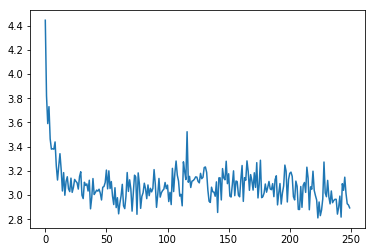

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)